In [30]:
import os
import json
from typing import List, Dict, Optional, Union, Tuple

import pandas as pd
import matplotlib.pyplot as plt

# Environments

In [110]:
KERNEL_TYPE = os.environ.get('KAGGLE_KERNEL_RUN_TYPE','').upper()
IS_KAGGLE = KERNEL_TYPE != ''
print('================================================')
if IS_KAGGLE:
    print(f'Notebook is running on Kaggle ({KERNEL_TYPE} mode)')
else:
    print(f'Notebook is running locally')
print('================================================')

Notebook running in INTERACTIVE mode.


# Parameters and Conatants

In [7]:
DATADIR = '/kaggle/input/setfit-emotion'
TRAIN_DATA_PATH = os.path.join(DATADIR, 'train.jsonl')
VALID_DATA_PATH = os.path.join(DATADIR, 'validation.jsonl')
TEST_DATA_PATH = os.path.join(DATADIR, 'test.jsonl')

In [8]:
DEBUG = True

# Utilities

In [19]:
def read_jsonl(path, st: Optional[int] = None, ed: Optional[int] = None) -> pd.DataFrame:
    record = []
    with open(path, 'r') as fp:
        for i, line in enumerate(fp.readlines()):
            if st is not None and i < st:
                continue
            if ed is not None and i > ed:
                continue
            row = json.loads(line)
            record.append(row)
    return pd.DataFrame.from_records(record)


if DEBUG:
    df = read_jsonl(TEST_DATA_PATH)
    print(df)

                                                   text  label label_text
0     im feeling rather rotten so im not very ambiti...      0    sadness
1             im updating my blog because i feel shitty      0    sadness
2     i never make her separate from me because i do...      0    sadness
3     i left with my bouquet of red and yellow tulip...      1        joy
4       i was feeling a little vain when i did this one      0    sadness
...                                                 ...    ...        ...
1995  i just keep feeling like someone is being unki...      3      anger
1996  im feeling a little cranky negative after this...      3      anger
1997  i feel that i am useful to my people and that ...      1        joy
1998  im feeling more comfortable with derby i feel ...      1        joy
1999  i feel all weird when i have to meet w people ...      4       fear

[2000 rows x 3 columns]


# Data Visualization

In [29]:
if DEBUG:
    labels = df[['label', 'label_text']].groupby('label').first().sort_index()
    print(labels)

      label_text
label           
0        sadness
1            joy
2           love
3          anger
4           fear
5       surprise


In [61]:
def get_labels(df: pd.DataFrame):
    labels = df[['label', 'label_text']].groupby('label').first().sort_index()
    return labels


def plot_label_counts(df: pd.DataFrame, name: str = '', ax: Optional = None):
    if ax is None:
        fig, ax = plt.subplots()
    vc = df['label_text'].value_counts()
    ax.bar(vc.keys(), vc.values)
    ax.set_ylabel('# Records')
    ax.set_title(name)
    ax.grid()
    return ax


def plot_label_text_length(df: pd.DataFrame, name: str = '', ax: Optional = None):
    if ax is None:
        fig, ax = plt.subplots()
    for label_text, _df in df.groupby('label_text'):
        textlen = _df['text'].apply(len)
        ax.hist(textlen, alpha=0.5, density=True, label=label_text)
    ax.set_title(name)
    ax.set_xlabel('Text length')
    ax.set_ylabel('% Records')
    ax.legend()
    ax.grid()

,label_text
0,sadness
1,joy
2,love
3,anger
4,fear
5,surprise


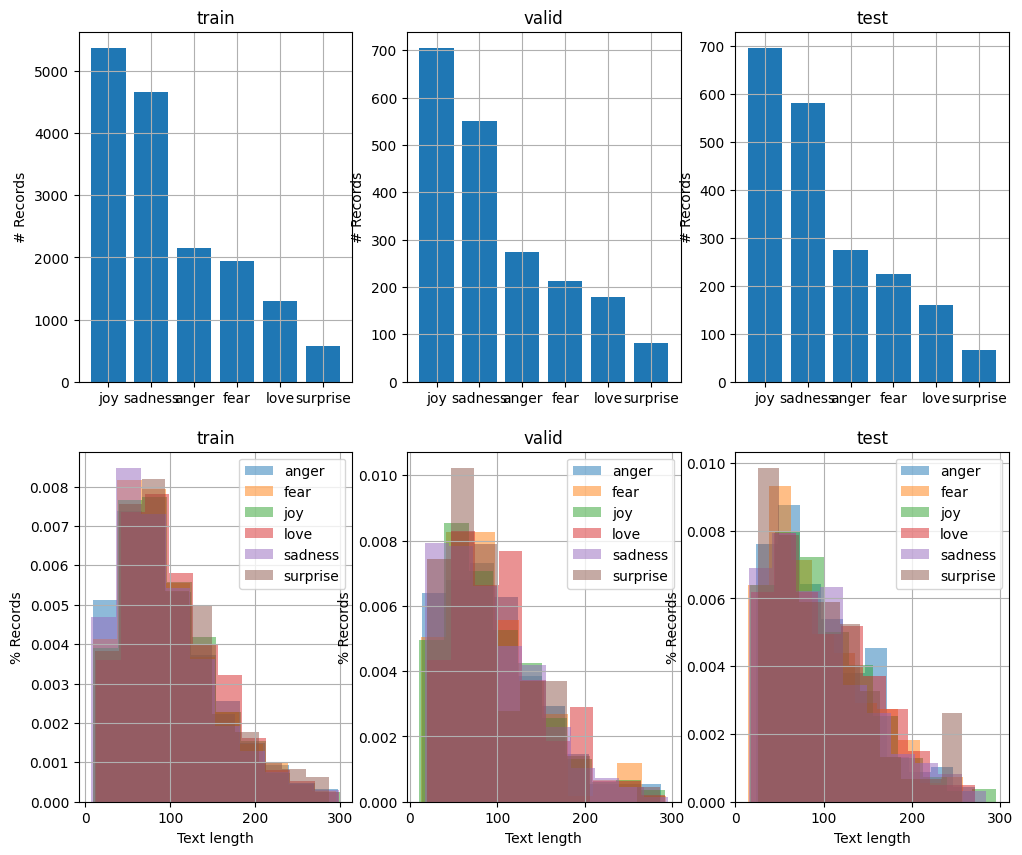

In [62]:
def visualization(**dfs: Dict[str, pd.DataFrame]):
    labels = None
    for name, df in dfs.items():
        if labels is None:
            labels = get_labels(df)
        else:
            labels = pd.merge(labels, get_labels(df))
    display(labels)

    fig, axs = plt.subplots(2, len(dfs), figsize=(4*len(dfs), 5*2))
    for i, (name, df) in enumerate(dfs.items()):
        # label counts
        plot_label_counts(df, ax=axs[0,i], name=name)
    
        # label-text length
        plot_label_text_length(df, ax=axs[1,i], name=name)
    plt.show()

if DEBUG:
    df_train = read_jsonl(TRAIN_DATA_PATH)
    df_valid = read_jsonl(VALID_DATA_PATH)
    df_test  = read_jsonl(TEST_DATA_PATH)
    visualization(
        train=df_train,
        valid=df_valid,
        test =df_test,
    )

# Data Check

## Duplication Check
To check if there is any text content appears in multiple records.

In [89]:
def check_duplication(df: pd.DataFrame):
    for text, _df in df.groupby('text'):
        if len(_df) == 1:
            continue
        labels = _df['label_text'].unique()
        print(f'TEXT: "{text}"\nCOUNTS: {len(_df)} LABELS: {labels}\n')
    
if DEBUG:
    # check_duplication(df_train)
    print(df_train[df_train['text'] == 'i am not amazing or great at photography but i feel passionate about it'])

                                                   text  label label_text
3508  i am not amazing or great at photography but i...      1        joy
8246  i am not amazing or great at photography but i...      2       love


## Leakage Check
To check if there are records in the **validation**/**test** dataset **similar**/**indentical** to the **train** dataset

In [109]:
def find_leakage(df_ref, *dfs, ref_name='ref', names=()):
    """ find records of `df` that has text also appears in `df_ref` reocrds"""
    
    assert len(dfs) == len(names)
    
    df_ref = df_ref.groupby('text')['label_text'].agg(['unique'])

    df_merge = []
    for df, name in zip(dfs, names):
        df = df.groupby('text')['label_text'].agg(['unique'])
        _df = pd.merge(df_ref, df, on='text', how='inner', suffixes=('_'+ref_name, '_'+name))
        df_merge.append(_df)
    df_merge = pd.concat(df_merge, ignore_index=False, sort=False)
    display(df_merge)


find_leakage(df_train, df_valid, df_test, ref_name='train', names=('valid', 'test'))

,unique_train,unique_valid,unique_test
text,,,
i feel completely blessed to be a part of this group,[love],[joy],NaN
i feel so blessed to be a part of your days,[love],[joy],NaN
i feel that being faithful isnt enough in your eyes,[joy],[love],NaN
i honestly feel at heart we should be faithful to each other if its yo girl,[joy],[love],NaN
i miss our talks our cuddling our kissing and the feelings that you can only share with your beloved,[joy],[love],NaN
i am feeling stressed and more than a bit anxious,[sadness],NaN,[anger]
i could feel his breath on me and smell the sweet scent of him,[love],NaN,[joy]
i feel cared for and accepted,[joy],NaN,[love]
i feel like some of you have pains and you cannot imagine becoming passionate about the group or the idea that is causing pain,[love],NaN,[joy]
